# IndieP: Predicting the Success of Indie Games on Steam

# Part 2: Data Cleaning

<div align="center"><img src="./data_cleaning.jpeg", title="Image from becominghuman.ai", width="50%"/></div>

In [Part 1](https://github.com/argwood/IndieP/blob/master/IndieP_Data_Collection.ipynb) of this project, we collected a dataset of roughly 22,700 Indie Games including information about the games themselves, collected using the Steam Storefront API, as well as popularity data such as ratings and number of users, collected using the SteamSpy API. The data we collected so far, however, is a bit of a mess and in no way suited for data exploration let alone any machine learning algorithms. We have columns with missing data, columns with json objects embedded inside of them, columns of long markdown text, different ways of handling missing data (0's versus NaNs), and more. Thus, the process of cleaning up our data to be usable and look presentable will be crucial to the next phases of this project. 

As a number of Steam game datasets exist already on [Kaggle](https://www.kaggle.com/nikdavis/steam-store-games), I tried not to be influenced by their decisions on how each clean feature should look - though of course, in many places, there's only one "best" way to do things.

## 2. Data Cleaning

**The goal of the second part of this project is to take the messy datasets we created in Part 1, and transform them into one dataset that is presentable, usable, easy to read, and contains only the columns that we are interested in for the later stages of the project.** As mentioned previously, we ultimately want to discover what features have the greatest effect on the success of a game, and thus the features we will focus on include qualities of the games themselves (price, genres, game descriptions, number of achievements, etc), and metrics that may be useful for quantifying sucess, such as ratings, number of users, and number of copies purchased. 

We will begin this part of the project by taking a look at the data we collected, and making sure our list of AppIDs matches the AppIDs in the full dataset (ensuring we didn't miss any or make any API requests twice, when collecting the data). We will decide how to handle the AppIDs that weren't found by the API, and then investigate other missing data. From here, we will perform transformations on the columns that are messy or have mixed datatypes, and then finally combine the two datasets from the Steam API and SteamSpy API into one table. In Part 4, we will apply some final data transformations on alphanumerical features to prepare them for input to machine learning algorithms, but otherwise at the end of this section we will obtain our final dataset to be used for the remainder of this project.

In general, for data cleaning, we'll want to consider how to deal with the following types of scenarios:
1. **Missing Values:** We can either choose to remove full columns (features) with too much missing data, remove full rows (games) with too much missing data, or fill the data in by using averages or regression. We can also transform columns with a lot of missing data into `Yes/No` binary columns indicating whether this feature exists (we will do this for DLC/packages, later) 
2. **Special Values:** Make sure that special characters such as infinity, NA and NaN are handled uniformly and won't be part of any future calculations upon those features. Additionally, we'll make sure all prices are formatted uniformly.
3. **Text Formatting:** Remove messy markdown text from features that include long pieces of text. We'll also reformat columns of json objects into cleaner lists.
4. **Outliers**: Check for outliers, and decide based on the feature, type, etc, if they should be kept or removed.
5. **Inconsistencies**: Look for inconsistencies such as negative prices, release dates in the future but `coming_soon` listed as false, `is_free` listed as true but a price provided in `price_overview`, etc. 

**Note that while this full notebook is created using Pandas, a lot of the commands executed are much better suited for SQL (pretty much every SQL command can be executed with Pandas, but sometimes a simple SQL command like `SELECT * FROM data_steam WHERE developers == publishers`) is unneccessarily messy in Pandas. In fact, after this Part of our project, we'll take a detour to SQL-land, where we will save our data as a SQLite database and do a bit of analysis and cleaning with SQL, mostly just to show the comparison. We'll also use SQL to join our Steam and SteamSpy tables, as a relational database is ideal for the data framework we will have.** 

### 2.0 Useful Resources for Data Cleaning

Most of my knowledge of data cleaning comes from a class I took at the University of Chicago, but here are some additional resources I used for Part 2 of this project.

1. Intro to Data Engineering - University of Chicago, Dept. of Computer Science (2019)
2. [The Ultimate Guide to Data Cleaning](https://towardsdatascience.com/the-ultimate-guide-to-data-cleaning-3969843991d4)
3. [Daniel Bourke's Guide to Exploratory Data Analysis](https://towardsdatascience.com/a-gentle-introduction-to-exploratory-data-analysis-f11d843b8184)
3. [Becoming Human: AI Article on Data Cleaning](https://becominghuman.ai/day-7-data-cleaning-all-that-you-need-to-know-about-it-23b05738abe7)
4. [Data Science Workbook by Daniel Martinez](https://github.com/dformoso/sklearn-classification/blob/master/Data%20Science%20Workbook%20-%20Census%20Income%20Dataset.ipynb)

### 2.1 Initial Investigation of Missing Data for Steam Dataset

In [1]:
import csv
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno
from ast import literal_eval
import re

pd.set_option("max_columns", 1000)

We can start by taking a look at the first few rows of both datasets, to get a feel for what we're dealing with. Even in the first few rows, we can see missing data, messy markdown and html formatting, and json objects embedded inside columns. After seeing how much data we're missing, we'll then go column-by-column to clean up each of these issues.

In [238]:
data_steam_raw = pd.read_csv('./data/steam_data.csv')
data_steamspy_raw = pd.read_csv('./data/steamspy_data.csv')

In [239]:
data_steam_raw.head(2)

,type,name,steam_appid,required_age,is_free,about_the_game,short_description,supported_languages,header_image,website,developers,publishers,price_overview,packages,package_groups,platforms,categories,genres,screenshots,movies,achievements,release_date,background,content_descriptors
0,game,***,1034230,0.0,False,*** is a small game.<br />\r\nIt is easy to pl...,"*** is a small game. It is easy to play,hope y...","English<strong>*</strong>, French<strong>*</st...",https://steamcdn-a.akamaihd.net/steam/apps/103...,NaN,['Kenshin Game Studio'],['Kenshin Game Studio'],"{'currency': 'USD', 'initial': 99, 'final': 99...",[344162],"[{'name': 'default', 'title': 'Buy ***', 'desc...","{'windows': True, 'mac': False, 'linux': False}","[{'id': 2, 'description': 'Single-player'}]","[{'id': '4', 'description': 'Casual'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://steamcdn...","[{'id': 256744684, 'name': 'V0.3', 'thumbnail'...",NaN,"{'coming_soon': False, 'date': 'Mar 17, 2019'}",https://steamcdn-a.akamaihd.net/steam/apps/103...,"{'ids': [], 'notes': None}"
1,game,- Arcane Raise -,603750,0.0,False,"<img src=""https://steamcdn-a.akamaihd.net/stea...",Arcane Raise is a role-playing video game fran...,English<strong>*</strong><br><strong>*</strong...,https://steamcdn-a.akamaihd.net/steam/apps/603...,NaN,['Arcane Raise'],['WAX Publishing'],"{'currency': 'USD', 'initial': 299, 'final': 2...",[158866],"[{'name': 'default', 'title': 'Buy - Arcane Ra...","{'windows': True, 'mac': True, 'linux': True}","[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '25', 'description': 'Adventure'}, {'i...","[{'id': 0, 'path_thumbnail': 'https://steamcdn...","[{'id': 256680620, 'name': 'Arcane Raise - Lau...","{'total': 37, 'highlighted': [{'name': 'Letter...","{'coming_soon': False, 'date': 'Mar 10, 2017'}",https://steamcdn-a.akamaihd.net/steam/apps/603...,"{'ids': [], 'notes': None}"


As the first step to dealing with missing data, the's a really nice python package called Missingno that lets you visualize how many missing data points are in each column of data:

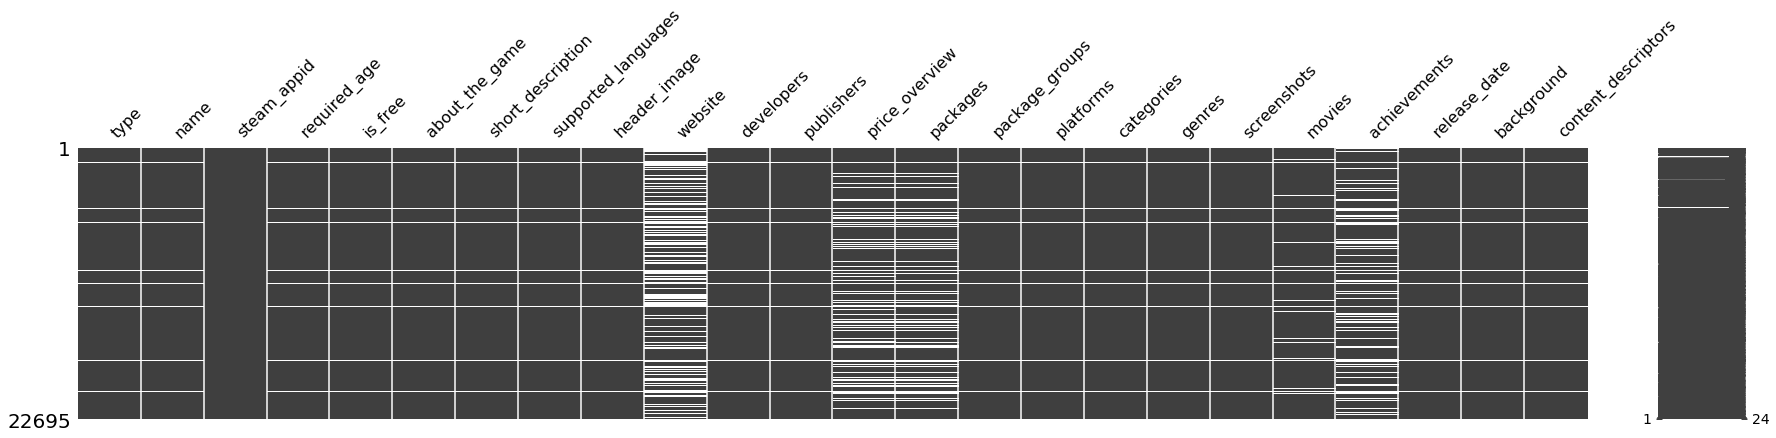

In [4]:
missingno.matrix(data_steam_raw, figsize = (30,5))

The black areas represent existing data, while the white is data that is missing. We can see right off the bat the the columns `website`, `price_overview`, `packages`, and `achievements` have the most missing values.`Movies` has some data missing as well. On the contrary, `steam_appid` has no missing values, since we guaranteed this column to be filled in during our data collection. The full rows with missing data (apart from `steam_appid`) are likely Steam API requests that came back with no result, and thus only the `steam_appid` was entered.

**We need to decide whether or not to keep the sparse columns and rows:** at first glance, `website` might not influence the success of a game, although one could argue that having better marketing and internet presence would make a game better-known. `Price_overview` is likely sparse due to the fact that free games have this column blank - we definitely want to keep this column, but will need to transform it to take into account the free games. `Packages` provides AppIDs for any DLC or additional media, if present, and is blank if there is none - we want to keep this as well, although it's less important than the pricing, because perhaps games with more content are more popular. However, we aren't interested in the exact AppIDs for the packages, so we'll transform this column later into a simple "Yes/No" column. We'll do something similar for `achievements`, which specifies the number of achievements each game has, and fill in the missing values with 0's (i.e., no achievements).  

For now, let's keep all of the columns except for `movies`, which probably isn't too useful, and we aren't planning to do in-depth image analysis with movies (we may for the still images, though).

In [240]:
cols_to_delete = ['movies']
data_steam = data_steam_raw.drop(columns=cols_to_delete) #save to new dataframe so that we don't overwrite the raw data

Next, we want to remove all of the rows of AppIDs that were not found by the Steam API - since this is only a small portion of our dataset, it shouldn't be a problem to just get rid of them rather than try to find out why they failed the API requests. We can keep a list of the AppIDs we're deleting, in case we want to investigate later to get more data. 

The easiest way to take care of this is to remove all rows where `type` is blank. While we're at it, we want to remove any "non-game" apps that accidentally slipped through our filters (turns out, there's one soundtrack and two DLCs that we don't want).

In [5]:
data_steam['type'].value_counts(dropna=False)

game     21967
NaN        725
dlc          2
music        1
Name: type, dtype: int64

In [241]:
print('Number of blank rows to remove:', data_steam[data_steam['type'].isnull()].shape[0])
data_steam_noAPIresponse = data_steam[data_steam['type'].isnull()]['steam_appid'] #save the deleted appids to a new list just in case
data_steam_noAPIresponse.head(3)

Number of blank rows to remove: 725


36    628340
58    951090
81    841860
Name: steam_appid, dtype: int64

In [242]:
data_steam = data_steam[data_steam.type == 'game'] #only keep rows where type='game'

In [243]:
data_steam['type'].value_counts(dropna=False)

game    21967
Name: type, dtype: int64

Now that we've removed some of the rows we don't want, we can take a look at our Missingno matrix again before we tackle the rest of the cleaning column-by-column:

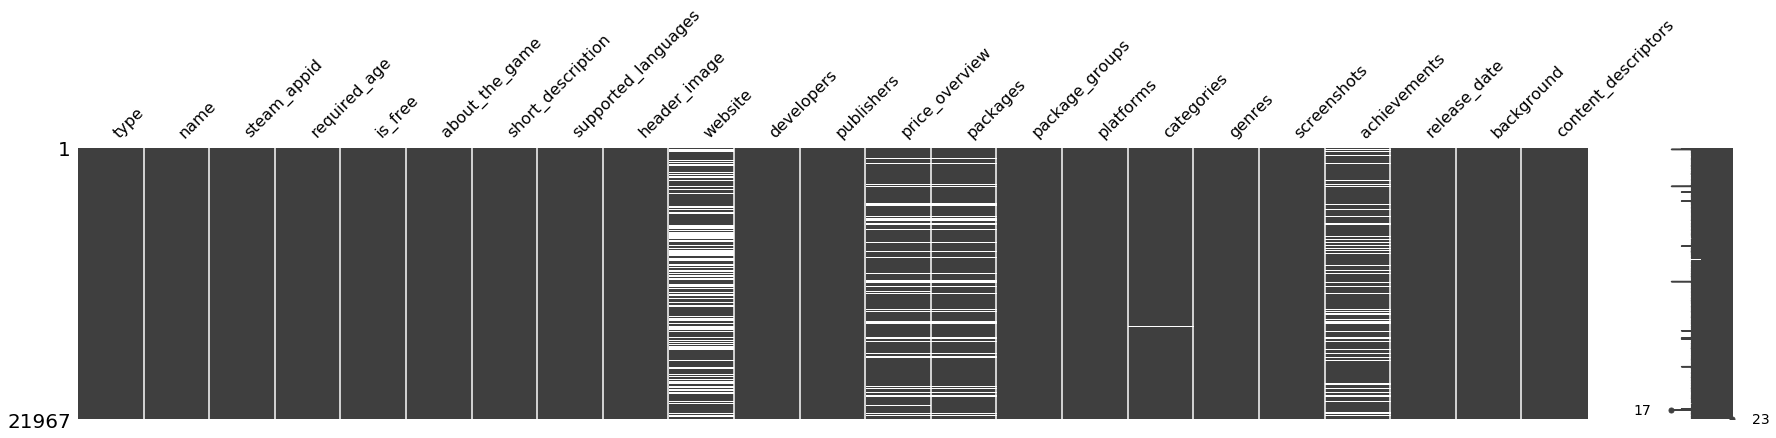

In [10]:
missingno.matrix(data_steam, figsize = (30,5))

It looks much better already! There's something going on with `categories`, though, that we'll deal with later.

Finally, before we move on, we want to check for duplicate rows, as we did at the beginning of Part 1.

In [9]:
data_steam[data_steam.duplicated(subset='steam_appid')]

,type,name,steam_appid,required_age,is_free,about_the_game,short_description,supported_languages,header_image,website,developers,publishers,price_overview,packages,package_groups,platforms,categories,genres,screenshots,achievements,release_date,background,content_descriptors


Awesome, no duplicates!

### 2.2 Steam Dataset: Feature Cleaning

Now that we've removed the rows and columns we're sure we don't want (though of course, we may change our minds later), we'll go through the columns of the dataset one-by-one and clean up the data as well as improve the readability of their labels in some cases.

### Feature 1: Type

Since we've already removed all the rows that have a `type` other than "game", this column is now entirely unneccessary. We can just remove it.

In [244]:
data_steam.drop('type', axis=1, inplace=True)

In [245]:
data_steam.head(1)

,name,steam_appid,required_age,is_free,about_the_game,short_description,supported_languages,header_image,website,developers,publishers,price_overview,packages,package_groups,platforms,categories,genres,screenshots,achievements,release_date,background,content_descriptors
0,***,1034230,0.0,False,*** is a small game.<br />\r\nIt is easy to pl...,"*** is a small game. It is easy to play,hope y...","English<strong>*</strong>, French<strong>*</st...",https://steamcdn-a.akamaihd.net/steam/apps/103...,NaN,['Kenshin Game Studio'],['Kenshin Game Studio'],"{'currency': 'USD', 'initial': 99, 'final': 99...",[344162],"[{'name': 'default', 'title': 'Buy ***', 'desc...","{'windows': True, 'mac': False, 'linux': False}","[{'id': 2, 'description': 'Single-player'}]","[{'id': '4', 'description': 'Casual'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://steamcdn...",NaN,"{'coming_soon': False, 'date': 'Mar 17, 2019'}",https://steamcdn-a.akamaihd.net/steam/apps/103...,"{'ids': [], 'notes': None}"


### Feature 2: Name

There's not a whole lot to be done for the `name` feature, as it sort of is what it is - a name. There's no guarantee that all of the names are unique, or that they are all in English (though we filtered to only include games that are playable in English, the titles aren't required to be). For example, there are three games named "Exodus", and only one out of the first 7 games in our dataset has a title that is entirely alphanumeric:

In [246]:
data_steam['name'].value_counts(dropna=False).head(7)

Exodus         3
Surge          3
Lost           3
Dark Matter    3
The Tower      3
Fireflies      3
Rise           2
Name: name, dtype: int64

In [247]:
data_steam['name'].str.isalnum().head(7)

0    False
1    False
2    False
3     True
4    False
5    False
6    False
Name: name, dtype: bool

### Feature 3: AppID 

Like `name`, the `steam_appid` is pretty standardized, and we've already filtered out the duplicates. One thing we'll do is rename the column to `appid` since "steam" is redundant.

In [248]:
data_steam.rename(columns={'steam_appid':'appid'},inplace=True)

In [249]:
data_steam.head(1)

,name,appid,required_age,is_free,about_the_game,short_description,supported_languages,header_image,website,developers,publishers,price_overview,packages,package_groups,platforms,categories,genres,screenshots,achievements,release_date,background,content_descriptors
0,***,1034230,0.0,False,*** is a small game.<br />\r\nIt is easy to pl...,"*** is a small game. It is easy to play,hope y...","English<strong>*</strong>, French<strong>*</st...",https://steamcdn-a.akamaihd.net/steam/apps/103...,NaN,['Kenshin Game Studio'],['Kenshin Game Studio'],"{'currency': 'USD', 'initial': 99, 'final': 99...",[344162],"[{'name': 'default', 'title': 'Buy ***', 'desc...","{'windows': True, 'mac': False, 'linux': False}","[{'id': 2, 'description': 'Single-player'}]","[{'id': '4', 'description': 'Casual'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://steamcdn...",NaN,"{'coming_soon': False, 'date': 'Mar 17, 2019'}",https://steamcdn-a.akamaihd.net/steam/apps/103...,"{'ids': [], 'notes': None}"


While we're at it, let's also sort the dataframe by AppID - this will help us combine this dataset with the SteamSpy dataset later on, and also improves readability overall.

In [250]:
data_steam.sort_values(by=['appid'], inplace=True)
data_steam = data_steam.reset_index(drop=True)

In [251]:
data_steam.head(3)

,name,appid,required_age,is_free,about_the_game,short_description,supported_languages,header_image,website,developers,publishers,price_overview,packages,package_groups,platforms,categories,genres,screenshots,achievements,release_date,background,content_descriptors
0,Rag Doll Kung Fu,1002,0.0,False,Featuring a wide collection of single and mult...,Featuring a wide collection of single and mult...,English,https://steamcdn-a.akamaihd.net/steam/apps/100...,http://www.ragdollkungfu.com/,['Mark Healey'],['Mark Healey'],"{'currency': 'USD', 'initial': 999, 'final': 9...",[45],"[{'name': 'default', 'title': 'Buy Rag Doll Ku...","{'windows': True, 'mac': False, 'linux': False}","[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '23', 'description': 'Indie'}]","[{'id': 0, 'path_thumbnail': 'https://steamcdn...",{'total': 0},"{'coming_soon': False, 'date': 'Oct 12, 2005'}",https://steamcdn-a.akamaihd.net/steam/apps/100...,"{'ids': [], 'notes': None}"
1,Darwinia,1500,0.0,False,Combining fast-paced action with strategic bat...,Combining fast-paced action with strategic bat...,"English, German",https://steamcdn-a.akamaihd.net/steam/apps/150...,http://www.darwinia.co.uk/,['Introversion Software'],['Introversion Software'],"{'currency': 'USD', 'initial': 999, 'final': 9...","[54, 14324, 978, 14002]","[{'name': 'default', 'title': 'Buy Darwinia', ...","{'windows': True, 'mac': True, 'linux': True}","[{'id': 2, 'description': 'Single-player'}]","[{'id': '23', 'description': 'Indie'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://steamcdn...",{'total': 0},"{'coming_soon': False, 'date': 'Jul 14, 2005'}",https://steamcdn-a.akamaihd.net/steam/apps/150...,"{'ids': [], 'notes': None}"
2,Uplink,1510,0.0,False,You play an Uplink Agent who makes a living by...,You play an Uplink Agent who makes a living by...,English,https://steamcdn-a.akamaihd.net/steam/apps/151...,http://www.uplink.co.uk/,['Introversion Software'],['Introversion Software'],"{'currency': 'USD', 'initial': 999, 'final': 9...","[112, 14002]","[{'name': 'default', 'title': 'Buy Uplink', 'd...","{'windows': True, 'mac': True, 'linux': True}","[{'id': 2, 'description': 'Single-player'}]","[{'id': '23', 'description': 'Indie'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://steamcdn...",{'total': 0},"{'coming_soon': False, 'date': 'Aug 23, 2006'}",https://steamcdn-a.akamaihd.net/steam/apps/151...,"{'ids': [], 'notes': None}"


### Feature 4: Required Age

Like the previous features we've looked at so far, the `age` column doesn't require too much work. There's no missing values, but we can see that a large majority of the data is `0` - there's no real way to tell if the developers meant that there really is no age restriction, or that they didn't supply this info and just put 0. Regardless, we can get a sense that this category might not be particularly useful, since only 1.5% of the data in this column is non-zero.

In [14]:
data_steam['required_age'].describe()

count    21967.000000
mean         0.221514
std          1.887051
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         20.000000
Name: required_age, dtype: float64

In [15]:
data_steam['required_age'].value_counts(dropna=False).sort_index()

0.0     21659
3.0         4
6.0         1
7.0         2
10.0       12
11.0        1
12.0       14
13.0       41
14.0        2
15.0        2
16.0       24
17.0      132
18.0       72
20.0        1
Name: required_age, dtype: int64

One thing that we can do to clean up this feature is apply some binning, so that there are fewer categories with only 1 or 2 items in them. Following the suggestion of Nik Davis, we can use a video game rating system to bin the ages into rating categories. Although video game rating systems vary widely throughout the world, In the United States the common rating system is the [ESRB](https://www.esrb.org/ratings-guide/) ratings, for example the commonly-seen "rated E for everyone." Following the description of each rating categories, we can break up our data into the following bins:

* **Everyone:** Ages 0+
* **Everyone 10+:** Ages 10+
* **Teen:** Ages 13+
* **Mature:** Ages 17+
* **Adults:** Ages 18+

In [252]:
def bin_age(df):
    '''Bin the age requirements to fit into 5 categories consistent with ESRB rating system'''
    
    bins = [-1, 0, 10, 13, 17, 30]
    labels = [0, 10, 13, 17, 18]
    df['required_age']=pd.cut(df['required_age'], bins = bins, labels = labels)
    return df

In [253]:
data_steam = bin_age(data_steam)

We can use the Python plotting package Seaborn to nicely visualize our bins. This is something we'll do throughout this project as we go through our remaining features. In doing so, we find that the large majority of data in this column is still 0, but with fewer bins the data becomes a lot more useful and nicer to visualize.

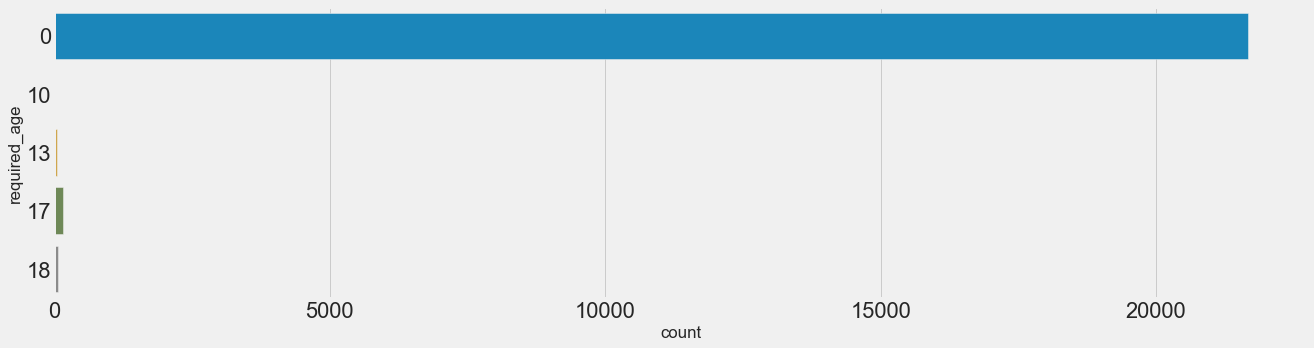

In [254]:
import seaborn as sns
sns.set(font_scale=2)
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(20,5)) 
sns.countplot(y="required_age", data=data_steam);

### Feature 5: Is Free

The `is_free` category is somewhat redundant, as we also have a category that specifically gives the price (with free games listed as 0). However, it may prove useful to keep a binary feature of whether or not a game is free - especially with Indie games, free games could be of very different quality than games that have pricetags (and especially considering Indie games are cheaper overall compared to games from more established companies that can be upwards of $100). 

For this category, the first thing we'll do is take a look at how many games are free versus paid. We use the Pandas `value_counts` function to get quantitative information as well as ensure there are no NaNs or missing data, and we use Seaborn's `countplot` to visualize.

In [255]:
data_steam['is_free'].value_counts(dropna=False)

False    20129
True      1838
Name: is_free, dtype: int64

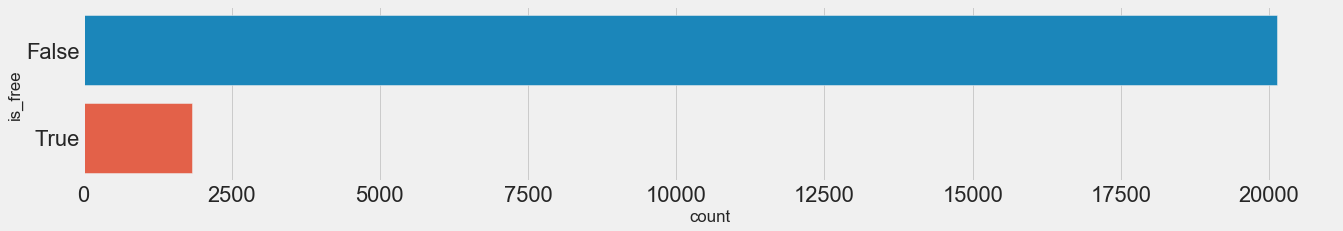

In [256]:
sns.set(font_scale=2)
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(20,3)) 
sns.countplot(y="is_free", data=data_steam);

The large majority of games are not free, however, there's certainly a non-negligible number of free games in the dataset as well. The only data cleaning we'll do for this feature is map the two options, `True` and `False` to a binary 1 or 0:

**Free (True)**: 1

**Not Free (False)**: 0

In [257]:
def map_to_binary(df, col, val1, val0):
    '''Takes a column with two values and maps it onto 1s and 0s'''
    
    df[col] = df[col].replace({val1: 1, val0: 0})

In [258]:
map_to_binary(data_steam, 'is_free', True, False) #note that the dtype of this column is Boolean, and we're converting to int

In [259]:
data_steam['is_free'].value_counts(dropna=False)

0    20129
1     1838
Name: is_free, dtype: int64

### Features 6 & 7: About the Game & Short Description

The `about_the_game` and `short_description` columns represent our first columns with text data where we have full sentences of information rather than structured data such as variable values. This unstructured data is much harder to deal with, and while we can investigate its contents using Natural Language Processing, other types of data analysis or Machine Learning models aren't suited to handle it. Thus, we'll need to make a decision about what we want to do with this kind of data. Will we use NPL to investigate what kinds of descriptions are provided by the developers? Maybe, but this would be a study following our initial investigation. 

We can also see that these two features are quite similar - in some cases, they are exact copies, while in other cases, `about_the_game` is a longer version of `short_description`:

In [27]:
data_steam['about_the_game'][0]

'Featuring a wide collection of single and multiplayer games, either online or with multiple mice, Rag Doll Kung Fu provides players with one of the most creative and unique game experiences delivered in years. Additionally, between those game rounds, the challenges of an aspiring Kung Fu master are revealed via outlandish cut scenes inspired by classic Kung Fu cinema.'

In [28]:
data_steam['short_description'][0]

'Featuring a wide collection of single and multiplayer games, either online or with multiple mice, Rag Doll Kung Fu provides players with one of the most creative and unique game experiences delivered in years.'

While I'm tempted to keep `short_description` in our dataset and entirely remove `about_the_game` due to redundancy, because this type of data is so different than the rest, we're going to move both of these columns to a new dataset with data for NLP and image analysis and keep the main dataset with only the columns we want to use for our predictive analysis. For now, we'll just mark these two columns "to be moved" and at the end of this section, we will move all of the desired columns at once. 

In [260]:
cols_to_move = ['about_the_game', 'short_description']

### Feature 8: Supported Languages

We've already filtered our dataset to include only games that are available in English, though many of these games are available in multiple other languages, as we can see by looking at the first few items in the column:

In [23]:
data_steam['supported_languages'].head()

0                                              English
1                                      English, German
2                                              English
3    English, French, German, Italian, Spanish - Spain
4    English, French, Italian, German, Spanish - Spain
Name: supported_languages, dtype: object

In [31]:
data_steam['supported_languages'].value_counts().head(10)

English                                                                                                        6908
English<strong>*</strong><br><strong>*</strong>languages with full audio support                               6227
English, Russian                                                                                                559
English, Simplified Chinese                                                                                     265
English, Japanese                                                                                               173
English<strong>*</strong>, Russian<strong>*</strong><br><strong>*</strong>languages with full audio support     156
English, French                                                                                                 142
English, Spanish - Spain                                                                                        118
English, German                                                         

For this feature, we could take two different approaches: We could combine similar values, such as "English" and "English with full audio support" (and accounting for different ordering of languages). However, I think it would be more helpful to transform the list of languages into a number indicating *how many* languages each game is available in. In thinking about a game's success, likely it would be more relevant to know how many languages (i.e. how large of an audience can the game reach?) rather than keep track of each and every language available - especially because there are so many different combinations and many combinations with only one one value count. Of course, how many people speak each language would also play into how large of an audience the game has, but this seems beyond the scope of this project and will be unlikely to directly correlate to how many people who speak that language actually play video games.

In [261]:
data_steam['supported_languages'] = data_steam['supported_languages'].str.split(',', expand=False) 

In [262]:
data_steam['supported_languages'].head()

0                                            [English]
1                                   [English,  German]
2                                            [English]
3    [English,  French,  German,  Italian,  Spanish...
4    [English,  French,  Italian,  German,  Spanish...
Name: supported_languages, dtype: object

In [263]:
def count_items_in_list(df, col, new_col):
    ''' Creates a new column that is the length of a list in another column '''
    
    df[new_col] = df[col].str.len()

In [264]:
count_items_in_list(data_steam, 'supported_languages', 'n_languages')

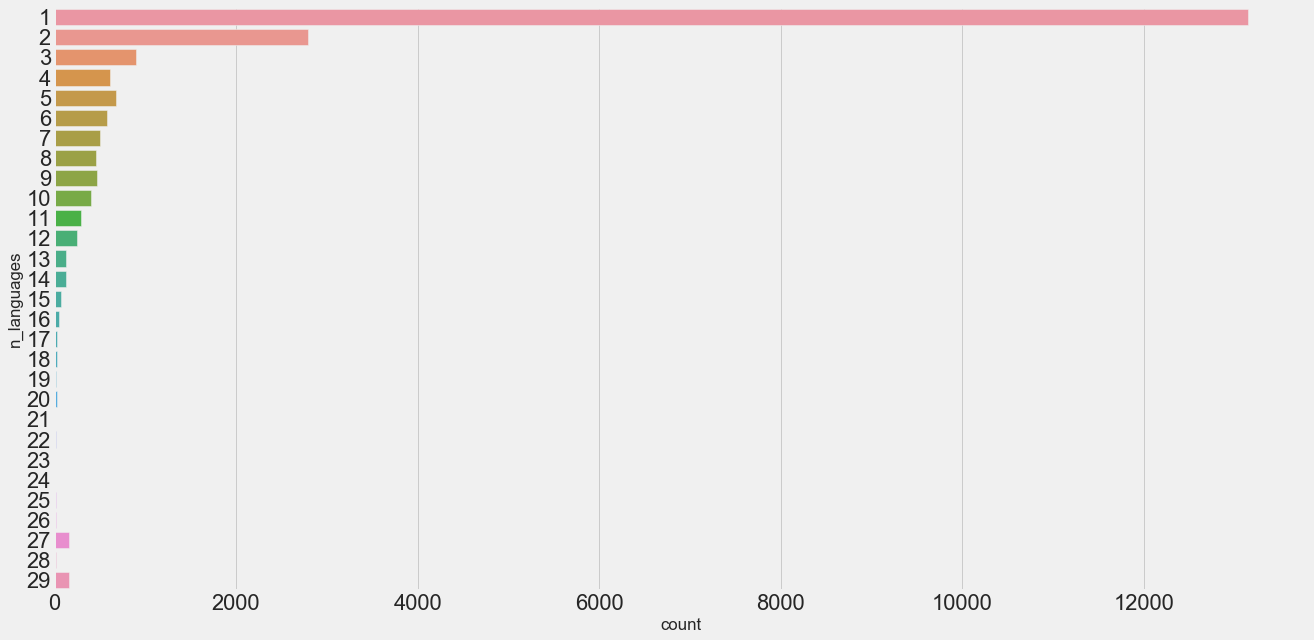

In [265]:
sns.set(font_scale=2)
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(20,10)) 
sns.countplot(y="n_languages", data=data_steam);

By visualizing the counts of `n_languages`, we can see that the vast majority of games are English-only, but that there's a fair number with an additional language supported. Further, there's some games with more languages, and the numbers trickle off at the number of languages increases. We note that there are a handful of games with 27 and 29 languages - are these outliers, errors, or are they accurate? Let's investigate by getting the row numbers of these outliers:

In [31]:
data_steam['n_languages'].sort_values(ascending=False).head(5)

18718    29
15272    29
19380    29
16873    29
4619     29
Name: n_languages, dtype: int64

We can look at the value of `supported_languages` for one of these rows using Pandas' `iloc` method:

In [37]:
data_steam.iloc[4619]['supported_languages']

['English',
 ' Swedish',
 ' French',
 ' Italian',
 ' German',
 ' Spanish - Spain',
 ' Arabic',
 ' Bulgarian',
 ' Czech',
 ' Danish',
 ' Dutch',
 ' Finnish',
 ' Greek',
 ' Hungarian',
 ' Japanese',
 ' Korean',
 ' Norwegian',
 ' Polish',
 ' Portuguese',
 ' Portuguese - Brazil',
 ' Romanian',
 ' Russian',
 ' Simplified Chinese',
 ' Thai',
 ' Traditional Chinese',
 ' Turkish',
 ' Ukrainian',
 ' Spanish - Latin America',
 ' Vietnamese']

There aren't any duplicates or typos, apart from including Spanish and Portuguese from two different areas of the world - my bet is that the developers just checked off all of the available languages (and I bet the next bunch of games at 27 languages is all languages without these two duplicates). The next question would be to verify if all of these languages are actually supported, but how would we do that without purchasing/downloading the game and switching the language? In any case, there's no real reason to believe these outliers are false, so we'll leave them in for now.

Since I don't necessarily want to delete the data in `supported_languages`, I'll mark it to be moved to our additional dataset with the unstructured data.

In [266]:
cols_to_move.append('supported_languages')

### Feature 9: Header Image

The `header_image` is an interesting feature to consider in an investigation of, for example, art style. This column is composed of links to the Steam store where the images are displayed - they're all unique (`head` and `tail` commands upon counting values both give 1), and there's no missing values.

In [33]:
data_steam['header_image'].value_counts(dropna=False).head(1)

https://steamcdn-a.akamaihd.net/steam/apps/724690/header.jpg?t=1567151741    1
Name: header_image, dtype: int64

In [34]:
data_steam['header_image'].value_counts(dropna=False).tail(1)

https://steamcdn-a.akamaihd.net/steam/apps/745380/header.jpg?t=1581151909    1
Name: header_image, dtype: int64

This feature will go directly into our dataset of unstructured data:

In [267]:
cols_to_move.append('header_image')

### Feature 10: Website

If you remember from earlier, when we visualized the missing data of each column, `website` was one of the columns with about half of its data missing, yet we kept it anyways. Below you can see how many values are missing:

In [268]:
data_steam['website'].isnull().sum()

7841

Similarly to how we handled the `is_free` column, we will be turning `website` into a binary categorical column for whether or not the game has a website:

**Has Website**: 1

**Does Not Have Website**: 0

In [269]:
def map_missing_to_binary(df, col, new_col):
    '''Takes a column with missing values and maps missing values to 0 and non-missing values to 1'''
    df[new_col] = df[col].notnull().astype('int')

In [270]:
map_missing_to_binary(data_steam, 'website', 'has_website')

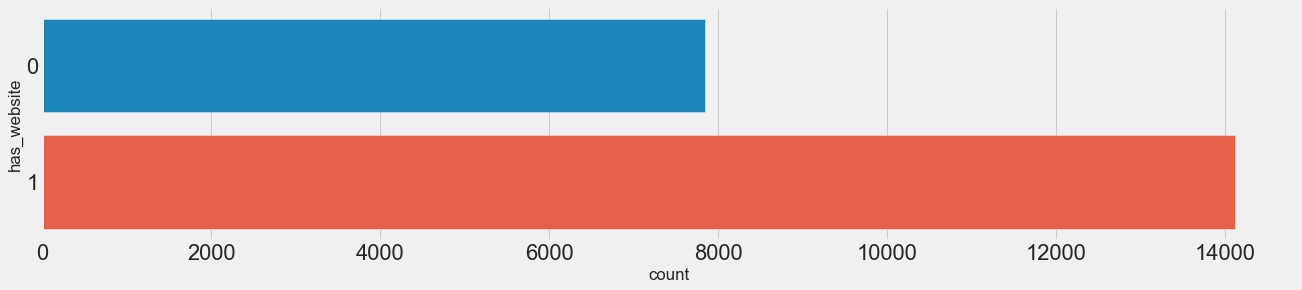

In [271]:
sns.set(font_scale=2)
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(20,4)) 
sns.countplot(y="has_website", data=data_steam);

In [272]:
cols_to_move.append('website') #keep the original data but move it to another dataset

### Features 11 & 12: Developers & Publishers

The `developers` and `publishers` features are quite similar to each other, and in fact often (but not always) they have the same values. By looking at the value counts of `developers`, we find that there are a handful of developers that have 20+ games, but the vast majority of developers have only one or a few games to their names. It will be interesting to later investigate if developers with many games have more successful games overall, and further to see if there's any difference between games where the developers and publishers are one and the same, compared to games with external publishers (or no publisher listed).

In [41]:
data_steam['developers'].value_counts().head(10)

['Choice of Games']             80
['Ripknot Systems']             60
['Hosted Games']                50
['RewindApp']                   47
['Nikita "Ghost_RUS"']          46
['Laush Dmitriy Sergeevich']    43
['For Kids']                    35
['Warfare Studios']             28
['NedoStudio']                  26
['DRUNKEN APES']                23
Name: developers, dtype: int64

In [45]:
data_steam['developers'].value_counts().tail(10)

['The Foregone Syndicate']                                                                                          1
['Among Giants']                                                                                                    1
['RobotKSR']                                                                                                        1
['Alexandre Rozier', 'Corentin Serrie', 'Sarah Gross', 'Ghislain Jeanneau', 'Nicolas Buisson', 'Alexandre Prot']    1
['Coronado Games']                                                                                                  1
['Entity Medialab']                                                                                                 1
['Spaceloom Studios AB']                                                                                            1
['Triple Lasers']                                                                                                   1
['睦月文化']                                                

For `publishers` in particular, we note that there are twice as many games with no publisher listed than there are for the most "popular" publisher - but that these numbers are barely even a fraction of the total number of items in our dataset.

In [46]:
data_steam['publishers'].value_counts().head(10)

['']                    190
['Choice of Games']      80
['Sekai Project']        72
['Devolver Digital']     62
['Ripknot Systems']      60
['PLAYISM']              59
['Plug In Digital']      58
['Artifex Mundi']        57
['RewindApp']            50
['Hosted Games']         50
Name: publishers, dtype: int64

First, we will check for missing values or empty lists (since we see above that this may be common):

In [184]:
print('# null values:', data_steam['developers'].isnull().sum())
print('# empty lists:', data_steam[data_steam['developers'] == "[]"].shape[0])

# null values: 49
# empty lists: 0


In [185]:
#no "null" values but a number of empty strings that should be handled the same
print('# null values:', data_steam['publishers'].isnull().sum()) 
print('# empty lists:', data_steam[data_steam['publishers'] == "['']"].shape[0])

# null values: 0
# empty lists: 190


To clean up these two features, we want to transform both from a list of strings to just a string with multiple developers or publishers separated by semicolons. This can be done quite easily with the `str.join()` method, but first we want to handle the missing values. Since there's only 49 missing values for developers and 149 for publishers, we could choose to remove these rows or list something like "None" for the publisher/developer. Both seem equally valid options, but let's do the former since it's such a small fraction of rows that will be affected.

We'll also remove the ~3 rows that have semicolons in their developer's names, so we can split on semicolons later.

In [273]:
data_steam = data_steam[(data_steam['developers'].notnull()) & (data_steam['publishers'] != "['']")].copy()
data_steam = data_steam[~(data_steam['developers'].str.contains(';')) & ~(data_steam['publishers'].str.contains(';'))]

In [189]:
print('# null values:', data_steam['publishers'].isnull().sum()) 
print('# empty lists:', data_steam[data_steam['publishers'] == "['']"].shape[0])

# null values: 0
# empty lists: 0


One caveat here: when we look at either of these columns, the data appears to be in list format. However, it's actually a string disguised as a list! We have to use the ["literal_eval" method from ast](https://docs.python.org/3/library/ast.html#ast.literal_eval) to convert it to a list. This is infinitely easier than writing a manual method for splitting and stripping on the commas and brackets, especially since some developers or publishers may have commas in their names.

In [190]:
type(data_steam.iloc[0]['publishers'])

str

In [274]:
def join_lists(df, col):
    df[col] = df[col].apply(lambda x: '; '.join(literal_eval(x)))

In [275]:
join_lists(data_steam, 'developers')

In [276]:
join_lists(data_steam, 'publishers')

In [277]:
data_steam['developers'].head(5)

0              Mark Healey
1    Introversion Software
2    Introversion Software
3    Introversion Software
4    Introversion Software
Name: developers, dtype: object

That looks so much better!

### Feature 13: Price Overview

Like the `developers`and `publishers` columns, `price overview` is a sneakily-disguised string that looks like a dictionary! It includes information such as discounts and the type of currency used, and most importantly the formatted price, which is the information we want to include in our dataset. We want to make sure that all of the rows have prices in USD, so we will extract both the "final formatted" and "currency" keys into separate columns, and investigate any rows with prices that are not in USD.

In [278]:
data_steam['price_overview'].iloc[0]

"{'currency': 'USD', 'initial': 999, 'final': 999, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': '$9.99'}"

In [279]:
def extract_price(df):
        
    def convert_price(x):
        if x is not np.nan:
            return literal_eval(x)
        else:
            return {'currency': 'USD', 'final_formatted': -1} #temporarily fill missing data in with -1
    
    df['price_overview'] = df['price_overview'].apply(convert_price) # evaluate dictionary
    df.head()
    # Create columns from currency and formatted price
    df['currency'] = df['price_overview'].apply(lambda x: x['currency'])
    df['price'] = df['price_overview'].apply(lambda x: x['final_formatted'])
    
    df.loc[df['is_free'], 'price'] = 0 #if game is free, set price to $0
    
    return df

In [280]:
data_steam = extract_price(data_steam)
data_steam.head(2)

,name,appid,required_age,is_free,about_the_game,short_description,supported_languages,header_image,website,developers,publishers,price_overview,packages,package_groups,platforms,categories,genres,screenshots,achievements,release_date,background,content_descriptors,n_languages,has_website,currency,price
0,Rag Doll Kung Fu,1002,0,0,Featuring a wide collection of single and mult...,Featuring a wide collection of single and mult...,[English],https://steamcdn-a.akamaihd.net/steam/apps/100...,http://www.ragdollkungfu.com/,Mark Healey,Mark Healey,"{'currency': 'USD', 'initial': 999, 'final': 9...",[45],"[{'name': 'default', 'title': 'Buy Rag Doll Ku...","{'windows': True, 'mac': False, 'linux': False}","[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '23', 'description': 'Indie'}]","[{'id': 0, 'path_thumbnail': 'https://steamcdn...",{'total': 0},"{'coming_soon': False, 'date': 'Oct 12, 2005'}",https://steamcdn-a.akamaihd.net/steam/apps/100...,"{'ids': [], 'notes': None}",1,1,USD,0
1,Darwinia,1500,0,0,Combining fast-paced action with strategic bat...,Combining fast-paced action with strategic bat...,"[English, German]",https://steamcdn-a.akamaihd.net/steam/apps/150...,http://www.darwinia.co.uk/,Introversion Software,Introversion Software,"{'currency': 'USD', 'initial': 999, 'final': 9...","[54, 14324, 978, 14002]","[{'name': 'default', 'title': 'Buy Darwinia', ...","{'windows': True, 'mac': True, 'linux': True}","[{'id': 2, 'description': 'Single-player'}]","[{'id': '23', 'description': 'Indie'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://steamcdn...",{'total': 0},"{'coming_soon': False, 'date': 'Jul 14, 2005'}",https://steamcdn-a.akamaihd.net/steam/apps/150...,"{'ids': [], 'notes': None}",2,1,USD,0


In [54]:
data_steam[data_steam['currency'] != 'USD']

,name,appid,required_age,is_free,about_the_game,short_description,supported_languages,header_image,website,developers,publishers,price_overview,packages,package_groups,platforms,categories,genres,screenshots,achievements,release_date,background,content_descriptors,n_languages,has_website,currency,price


Luckily, all of the games are already in USD - this is expected, since it was part of our initial filter when collecting the data, but it's always important to double check that our assumptions are true. Since we've confirmed that every value in `currency` is the same, we can drop this column:

In [281]:
data_steam = data_steam.drop(columns="currency")

In [282]:
data_steam = data_steam.drop(columns="price_overview")

In [283]:
data_steam['price'] = data_steam['price'].replace({-1: 0})

### Feature 14: Packages

The `packages` feature gives us a list of AppIDs relating to a given game, including DLC, soundtracks and more. This is definitely interesting, as it will be worth seeing if games that put more effort into media such as DLC and soundtracks are more successful over all, since they don't just put in the bare minimum for a game. However, we aren't particularly interested in knowing the AppIDs of every package for every game, since we aren't going to be cross-referencing these or doing any analysis of the extra media themselves. Instead, we will transform this column to give us information about **how many** packages each game has associated with it instead of having a list of them all. 

We can take a look at an example row for this feature to see the type of data we're working with initially:

In [284]:
data_steam['packages'].iloc[1]

'[54, 14324, 978, 14002]'

Like many of the other features, we have a string composed of a list of numbers (the AppIDs). All we want is the length of these lists, and we could do this easily two different ways: either we could convert the strings into their literal values, and then call len() on each list, or we could simply count the number of commas in each string and define the number of packages as the number of commas + 1. It would be interesting to do a study of the efficiency between these two methods, but since we've been using the former method all throughout the project, let's switch things up and trying something else. A simple `str.count()` function can take care of exactly what we want, assuming we handle the missing values correctly.

In [203]:
print('# missing values:', data_steam['packages'].isnull().sum()) 

# missing values: 3615


In [285]:
data_steam['n_packages'] = data_steam['packages'].str.count(',')

In [286]:
def add_one_or_set_to_zero(x):
    if not np.isnan(x): 
        return int(x+1)
    else:
        return int(0)

In [287]:
data_steam['n_packages'] = data_steam['n_packages'].apply(add_one_or_set_to_zero)

In [288]:
data_steam[['packages', 'n_packages']].head()

,packages,n_packages
0,[45],1
1,"[54, 14324, 978, 14002]",4
2,"[112, 14002]",2
3,"[156, 14325, 14002]",3
4,"[1002, 978, 14002]",3


Our new column, `n_packages` now gives us the number of packages attributed to each game as an integer. In the case of missing values, it was assumed that there were no packages for that game, and a value of 0 was imputed.

Before moving on, we can quickly visualize this new feature and see how many packages per game is most common.

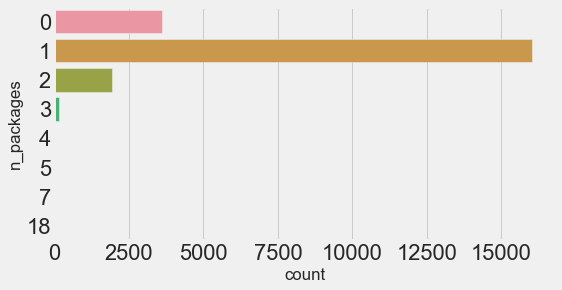

In [289]:
sns.set(font_scale=2)
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(8,4)) 
sns.countplot(y="n_packages", data=data_steam);

It looks like there's maybe some outliers worth investigating:

In [209]:
data_steam['n_packages'].value_counts()

1     16019
0      3615
2      1938
3       143
4        30
5         6
7         1
18        1
Name: n_packages, dtype: int64

In [210]:
data_steam['n_packages'].sort_values(ascending=False).head(2)

1097    18
626      7
Name: n_packages, dtype: int64

In [290]:
data_steam[['name', 'packages', 'n_packages']].iloc[1061]

name                                                   Influent
packages      [37206, 40596, 56319, 56318, 56317, 56316, 518...
n_packages                                                   18
Name: 1097, dtype: object

We might want to go through all of these AppIDs individually and see what they are and why this game has so many more packages than every other! We'll assume for now it's an outlier but not a mistake, but will check closer in the next Part of the project. For now, we'll just mark the original `packages` column to be moved so we don't lose this data, and then move on to the next feature.

In [291]:
cols_to_move.append('packages')

### Feature 15: Package Groups

The `package groups` feature extends on `packages` to give detailed information about the different ways that the game can be bought, including with and without discounts, with DLC, soundtracks or other media, paid for by a subscription, etc. We can take a look at an example row to see what kind of information it contains and if any of it may be useful for us:

In [108]:
data_steam['package_groups'].iloc[1]

"[{'name': 'default', 'title': 'Buy Darwinia', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 54, 'percent_savings_text': '', 'percent_savings': 0, 'option_text': 'Darwinia - $9.99', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 999}, {'packageid': 14324, 'percent_savings_text': '', 'percent_savings': 0, 'option_text': 'Darwinia + Soundtrack - $12.99', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 1299}, {'packageid': 978, 'percent_savings_text': '', 'percent_savings': 0, 'option_text': 'Multiwinia + Darwinia - $14.99', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 1499}, {'packageid': 14002, 'percent_savings_text': '', 'percent_savings': 0, 'option_text': 'Introversion Class

There's definitely an argument for claiming that games that entice potential buyers with deals on packages could be effective for getting more initial purchases, but I can't think of any strong argument for why having a package deal would make the game *better* or more successful in the long run - we haven't fully defined our term "success" yet (see Part 4!) but in my opinion a successful game is more than just a game that tricks users into buying copies so makes a lot of money but the game itself isn't particulary good at all. Plus, if the game isn't good, over time the ratings should provide this information, which would in turn (theoretically) bring down sales. This is, essentially, a long-winded way of saying that maybe this feature isn't necessary for our analysis. We already have the number of DLC packages per game saved as the `packages` feature, and the extra information here really isn't all that helpful.

In [292]:
data_steam = data_steam.drop(columns="package_groups")

### Feature 16: Platforms

The `platforms` feature gives us information about what types of computers are able to run the game. This is definitely important for us, since having a game available on more platforms will allow it to reach a larger audience. The current format for this feature is a dictionary-like string of Booleans for the three main platforms - Windows, Mac, and Linux. This isn't the worst way store this data, but it will be more useful to have just a list of available platforms for each game rather than the redundant Booleans (plus we don't want a feature with a full dictionary inside of it). 

There's a number of different ways we could convert this column to our final desired format, but we're going to take a similar approach to `price_overview` since the format is similar, create three temporary columns for Windows, Mac, and Linux, and then merge them into a list.

In [293]:
data_steam['platforms'].iloc[0]

"{'windows': True, 'mac': False, 'linux': False}"

In [294]:
print('# null values:', data_steam['platforms'].isnull().sum())
print('# empty lists:', data_steam[data_steam['platforms'] == "[]"].shape[0])

# null values: 0
# empty lists: 0


In [295]:
def extract_platforms(df):
        
    def convert_platforms(x):
        if x is not np.nan:
            return literal_eval(x)
        else:
            return {'windows': False, 'mac': False, 'linux': False}
    
    df['platforms'] = df['platforms'].apply(convert_platforms) # evaluate dictionary
    df.head()
    # Create columns from currency and formatted price
    df['windows'] = df['platforms'].apply(lambda x: x['windows'])
    df['mac'] = df['platforms'].apply(lambda x: x['mac'])
    df['linux'] = df['platforms'].apply(lambda x: x['linux'])
     
    df['windows'] = df['windows'].replace({True: 'Windows', False: ''}) #convert columns from Boolean to strings to then merge
    df['mac'] = df['mac'].replace({True: 'Mac', False: ''})
    df['linux'] = df['linux'].replace({True: 'Linux', False: ''})
    
    return df

In [296]:
data_steam = extract_platforms(data_steam)

In [297]:
data_steam[['windows', 'mac', 'linux']].head()

,windows,mac,linux
0,Windows,,
1,Windows,Mac,Linux
2,Windows,Mac,Linux
3,Windows,Mac,Linux
4,Windows,Mac,


We now have 3 nicely formatted columns that we can merge with our choice of separator - either a comma or a semicolon would make the most sense. The function below takes care of exactly that - for more comments on this ETL-like process, see the `release_date` section below (I did these all out of order, but essentially these two are the same!)

In [298]:
def merge_col(df, col1, col2, splitter):
    '''Replaces col1 with the concatenation of col1 and col2, separated by the delimiter provided. The delimiter is 
    ignored if either col1 or col2 are empty'''
    
    df[col1] = df[col1].str.cat(df[col2], sep = splitter)
    df[col1] = df[col1].replace({splitter: ''})
    df[col1] = df[col1].apply(lambda x: x[:-len(splitter)] if x.endswith(splitter) else x)
    df[col1] = df[col1].apply(lambda x: x[len(splitter):] if x.startswith(splitter) else x)
    return df

In [299]:
data_steam = merge_col(data_steam, 'windows', 'mac', '; ')

In [300]:
data_steam = merge_col(data_steam, 'windows', 'linux', '; ')

In [301]:
data_steam = data_steam.drop(columns=["mac", "linux", "platforms"])
data_steam.rename(columns={'windows':'platforms'},inplace=True)

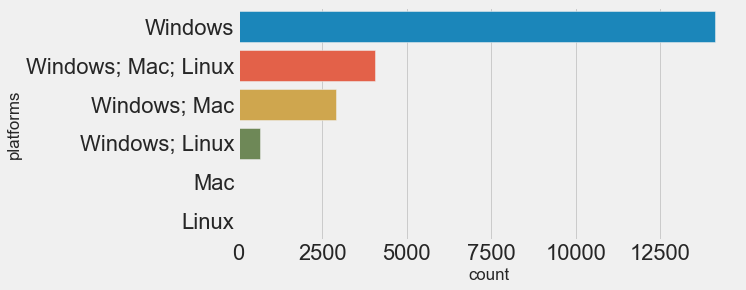

In [302]:
sns.set(font_scale=2)
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(8,4)) 
sns.countplot(y="platforms", data=data_steam);

By visualizing the frequency of each value in this feature, we see that, unexpectedly, the most common platform for indie games is Windows only. I'm surprised to see, though, that it's more common for games to be available on all three platforms than only Windows and Mac, since not nearly as many people play games on their Linux computers than on Mac or Windows. Finally, I'm not surprised to see that very few games are available on only Mac or only Linux. 

### Feature 17 & 18: Categories & Genres

We'd like the final format for both the `categories` and `genres` features to be quite similar to `platforms`, with a list of descriptors separated by semicolons. We can see that both `categories` and `genres` have raw data in similar format - strings of lists of dictionary-like objects. They also include a lot of information that it's too useful for us, such as the IDs corresponding to each category or genre. We're only interested in the descriptions themselves, so we'll filter out this key/value pair for both columns and note that, in both cases, there are a few (but not many) missing values to deal with. Do we keep these rows? Since there's fewer than 20 missing values and the categories will likely be one of the main features we will be working with later, let's just remove these rows.

In [303]:
data_steam['categories'].iloc[0]

"[{'id': 2, 'description': 'Single-player'}, {'id': 1, 'description': 'Multi-player'}]"

In [304]:
data_steam['genres'].iloc[0]

"[{'id': '23', 'description': 'Indie'}]"

In [305]:
print('# missing values:', data_steam['categories'].isnull().sum())

# missing values: 19


In [306]:
print('# missing values:', data_steam['genres'].isnull().sum())

# missing values: 5


In [307]:
data_steam = data_steam[(data_steam['categories'].notnull()) & (data_steam['genres'].notnull())] #remove missing data

These features will be cleaned in a similar manner to how we did `developers`. We will convert the column to literals, extracting the values of the keys we want, and joining them as a list separated by semicolons.

In [308]:
def extract_descriptions(df, col):
        
    df[col] = df[col].apply(lambda x: '; '.join(item['description'] for item in literal_eval(x)))
    
    return df

In [309]:
data_steam = extract_descriptions(data_steam, 'categories')
data_steam = extract_descriptions(data_steam, 'genres')

In [310]:
data_steam[['categories', 'genres']].head()

,categories,genres
0,Single-player; Multi-player,Indie
1,Single-player,Indie; Strategy
2,Single-player,Indie; Strategy
3,Single-player; Multi-player,Indie; Strategy
4,Single-player; Multi-player; Steam Achievements,Indie


### Feature 19: Screenshots

`Screenshots` is a feature much like `header`, which we dealt with previously. As with `header`, all we'll do here is mark this column to be moved to the dataset for unstructured data, and then at the end of this Part of the project, we will move all of the appropriate columns. We should keep in mind, however, that `screenshots` is much messier than `header` was: it's a list (technically a string that looks like a list) of dictionary items all containing information about different screenshots taken from the game. It will take some more cleaning later.

In [67]:
data_steam['screenshots'].iloc[0]

"[{'id': 0, 'path_thumbnail': 'https://steamcdn-a.akamaihd.net/steam/apps/1002/0000000205.600x338.jpg?t=1447350828', 'path_full': 'https://steamcdn-a.akamaihd.net/steam/apps/1002/0000000205.1920x1080.jpg?t=1447350828'}, {'id': 1, 'path_thumbnail': 'https://steamcdn-a.akamaihd.net/steam/apps/1002/0000000206.600x338.jpg?t=1447350828', 'path_full': 'https://steamcdn-a.akamaihd.net/steam/apps/1002/0000000206.1920x1080.jpg?t=1447350828'}, {'id': 2, 'path_thumbnail': 'https://steamcdn-a.akamaihd.net/steam/apps/1002/0000000207.600x338.jpg?t=1447350828', 'path_full': 'https://steamcdn-a.akamaihd.net/steam/apps/1002/0000000207.1920x1080.jpg?t=1447350828'}, {'id': 3, 'path_thumbnail': 'https://steamcdn-a.akamaihd.net/steam/apps/1002/0000000208.600x338.jpg?t=1447350828', 'path_full': 'https://steamcdn-a.akamaihd.net/steam/apps/1002/0000000208.1920x1080.jpg?t=1447350828'}, {'id': 4, 'path_thumbnail': 'https://steamcdn-a.akamaihd.net/steam/apps/1002/0000000209.600x338.jpg?t=1447350828', 'path_full'

In [311]:
cols_to_move.append('screenshots')

### Feature 20: Achievements

The `achievements` feature provides us information about the number of achievements available in each game. This feature has a lot of missing values, and where there is information, sometimes we're told that there are 0 achievements. When there are achievements, however, the values get messy and provide a lot of detail that we aren't interested in, such as specific examples of achievements. You can see an example here:

In [69]:
data_steam['achievements'].iloc[3]

"{'total': 22, 'highlighted': [{'name': 'Victory', 'path': 'https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1520/302ff34dc6d27d39a9095675c42b4e19b69c9ce0.jpg'}, {'name': 'Reserves', 'path': 'https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1520/14541a937e373e13c91c40639b7f30c2cf33e01e.jpg'}, {'name': 'Perfectly timed betrayal', 'path': 'https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1520/d460e13839e83e27b47cafa07237dca57c600b67.jpg'}, {'name': 'Pre-emptive striker', 'path': 'https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1520/8642da316fc433bbf4bf170c504dcac9a5cece9e.jpg'}, {'name': 'Kill The World', 'path': 'https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1520/0ac0dfd18db2d15c1f0fb46f72d0ba1c58ca1e18.jpg'}, {'name': 'Wasteful', 'path': 'https://steamcdn-a.akamaihd.net/steamcommunity/public/images/apps/1520/0dc815c1b3406b1a6c10e8bd3cce4400c6a8b632.jpg'}, {'name': 'Nice try', 'path': 'https://steam

And the number of missing values:

In [70]:
print('# missing values:', data_steam['achievements'].isnull().sum())

# missing values: 3871


All we want for this feature is to keep track of how many achievements each game has - in the case of missing values, we will assume that the game has zero achievements and impute the value "0". This can be done pretty straightforwardly, where we convert the dictionary-like string into a real string using `literal_eval` and then return the value of `total`. In the case of no data, we will instead return 0.

In [312]:
def get_n_achievements(x):
    try:
        x = literal_eval(x)
        return x['total']
    except ValueError:
        return '0'

In [313]:
data_steam['num_achievements'] = data_steam['achievements'].apply(get_n_achievements)

We can compare our new column with the original to ensure that our function was successful, and then go ahead and drop the original column, because it doesn't include any additional information that interests us.

In [314]:
data_steam[['achievements', 'num_achievements']].head()

,achievements,num_achievements
0,{'total': 0},0
1,{'total': 0},0
2,{'total': 0},0
3,"{'total': 22, 'highlighted': [{'name': 'Victor...",22
4,"{'total': 12, 'highlighted': [{'name': 'Domina...",12


In [315]:
data_steam = data_steam.drop(columns='achievements')
data_steam.rename(columns={'num_achievements':'achievements'},inplace=True)

Great! Before finishing, let's take a look at the distribution of number of achievements (note: I tried visualizing it, but it looked awful due to outliers, so here we are with the `describe` function).

In [75]:
data_steam['achievements'].astype('int').describe()

count    21753.000000
mean        38.411805
std        311.152117
min          0.000000
25%          0.000000
50%          7.000000
75%         21.000000
max       9821.000000
Name: achievements, dtype: float64

So...the max value is almost 10,000, while the average is 38. Let's investigate this outlier to see if it's a typo that we can remove.

In [316]:
data_steam = data_steam.reset_index(drop=True)

In [317]:
data_steam['achievements'].astype('int').idxmax() 

7541

In [318]:
data_steam.iloc[7545]

name                                                     Mistwood Heroes
appid                                                             573210
required_age                                                           0
is_free                                                                0
about_the_game         Mistwood is a huge forest-state populated by a...
short_description      Mistwood is a huge forest-state populated by a...
supported_languages                                            [English]
header_image           https://steamcdn-a.akamaihd.net/steam/apps/573...
website                                                              NaN
developers                                                      Meepower
publishers                                                      Meepower
packages                                                        [145818]
categories             Single-player; Steam Achievements; Full contro...
genres                             Action; Adventur

Checking out their website...this game really does have 9821 achievements! Okay. That's crazy. We almost certainly want to bin this feature when using it, but we'll leave it as is for the dataset we're creating. The binning will happen as we explore the data in the next Part of this project.

### Feature 21: Release Date

Like many of the other features we've dealt with so far, `release_date` is a string composed of a dictionary containing two key/value pairs: `coming_soon` and `date`. The goal for this feature is to remove all games that are "coming soon", because we won't have any ratings data for games that haven't been released yet. Then, we'll transform the column to just be a date in the format MM/DD/YYYY. This will be a nice excerise in data transformation (and one of the first examples I learned in a course on data engineering). 

In [319]:
data_steam['release_date'].head()

0    {'coming_soon': False, 'date': 'Oct 12, 2005'}
1    {'coming_soon': False, 'date': 'Jul 14, 2005'}
2    {'coming_soon': False, 'date': 'Aug 23, 2006'}
3    {'coming_soon': False, 'date': 'Sep 29, 2006'}
4    {'coming_soon': False, 'date': 'Sep 19, 2008'}
Name: release_date, dtype: object

In [80]:
print('# missing values:', data_steam['release_date'].isnull().sum())

# missing values: 0


Luckily, there's no distinct missing data, though I'm sure there's a lot of missing information when we dig in deeper into the dictionaries.

For the first step, we'll remove all the instances where `coming_soon=True`, and then create a column of dates in their original format. 

In [320]:
def remove_coming_soon(x):
    x = literal_eval(x)
    if x['coming_soon']:
        return '' # return blank string so can drop missing at end
    else:
        return x['date']

In [321]:
data_steam['release_date_transformed'] = data_steam['release_date'].apply(remove_coming_soon)

In [322]:
data_steam['release_date_transformed'].head(2)

0    Oct 12, 2005
1    Jul 14, 2005
Name: release_date_transformed, dtype: object

To change the date from this format to `MM/DD/YYYY`, we'll perform a series of transformations by splitting the column into multiple columns, applying rules to map the months to their respective numbers, and then combining the columns back into one. The functions we'll use are below: 

In [323]:
def split_col(df, col, new_col, splitter):
    '''Splits a column on a delimiter; replaces col with the substring before the delimiter, and makes a new col with the 
    substring after the delimiter. Assigns an empty string if the string does not contain the delimiter'''
    
    df[col], df[new_col] = df[col].str.split(splitter, 1).str
    df[new_col] = df[new_col].fillna('')
    return df

def convert(df, col, new_col, fn):
    '''Creates a new column where the a function is applied to a column'''
    
    df[col] = df[col].replace({'': np.nan})
    df[new_col] = df[col].map(fn, na_action='ignore')
    df[col] = df[col].fillna('')
    df[new_col] = df[new_col].fillna('')
    return df


def merge_col(df, col1, col2, splitter):
    '''Replaces col1 with the concatenation of col1 and col2, separated by the delimiter provided. The delimiter is 
    ignored if either col1 or col2 are empty'''
    
    df[col1] = df[col1].str.cat(df[col2], sep = splitter)
    df[col1] = df[col1].replace({splitter: ''})
    df[col1] = df[col1].apply(lambda x: x[:-len(splitter)] if x.endswith(splitter) else x)
    df[col1] = df[col1].apply(lambda x: x[len(splitter):] if x.startswith(splitter) else x)
    return df

In [324]:
data_steam = split_col(data_steam, 'release_date_transformed', 'release_date_transformed2', ', ') #split between day and year on comma

In [325]:
data_steam = split_col(data_steam, 'release_date_transformed', 'release_date_transformed3', ' ') #split between month and day on space

In [326]:
data_steam[['release_date_transformed','release_date_transformed2','release_date_transformed3']].head()

,release_date_transformed,release_date_transformed2,release_date_transformed3
0,Oct,2005,12
1,Jul,2005,14
2,Aug,2006,23
3,Sep,2006,29
4,Sep,2008,19


In [327]:
#convert months from their names to numerical equivalents, then convert the day from single digit to double-digit format

months = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08', 
             'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}

data_steam = convert(data_steam, 'release_date_transformed', 'release_month', lambda x: months.get(x))
data_steam = convert(data_steam, 'release_date_transformed3', 'release_day', lambda x: str('{:02d}'.format(int(x))))

In [328]:
data_steam[['release_date_transformed','release_date_transformed2','release_date_transformed3', 'release_month']].head()

,release_date_transformed,release_date_transformed2,release_date_transformed3,release_month
0,Oct,2005,12,10
1,Jul,2005,14,07
2,Aug,2006,23,08
3,Sep,2006,29,09
4,Sep,2008,19,09


In [329]:
data_steam = merge_col(data_steam, 'release_month', 'release_day', '/')
data_steam = merge_col(data_steam, 'release_month', 'release_date_transformed2', '/')

In [330]:
#delete extra columns and rename the one we want to keep
date_cols = ['release_date', 'release_date_transformed', 'release_date_transformed2', 'release_date_transformed3', 'release_day']
data_steam = data_steam.drop(columns=date_cols)
data_steam.rename(columns={'release_month':'release_date'},inplace=True)

In [357]:
print('# missing values:', data_steam['release_date'].isnull().sum())
print('# empty strings:', data_steam[data_steam['release_date'] == ""].shape[0])

# missing values: 0
# empty strings: 1994


The last thing we'll do is change the format of the column from a string to a datetime object 

In [92]:
#data_steam['release_date_formatted'] = pd.to_datetime(data_steam['release_date'])

In [93]:
#sns.distplot(data_steam["release_date"])

In [95]:
#data_steam = data_steam.drop(columns="release_date_formatted")

### Feature 22: Background

`Background` is again a feature much like `header`. It's just a string containing a link to an image. As with `header` and `screenshots`, all we'll do here is mark this column to be moved to the dataset for unstructured data, and then at the end of this Part of the project, we will move all of the appropriate columns.

In [96]:
data_steam['background'].iloc[0]

'https://steamcdn-a.akamaihd.net/steam/apps/1002/page_bg_generated_v6b.jpg?t=1447350828'

In [331]:
cols_to_move.append('background')

### Feature 23: Content Descriptors

We're almost done! The last feature in our Steam database is `content_descriptors`, which we can see technically has zero missing values:

In [98]:
data_steam['content_descriptors'].isnull().sum()

0

However, the missing values are actually hidden, and in fact nearly the whole column looks like an empty dictionary:

In [99]:
data_steam['content_descriptors'].iloc[0]

"{'ids': [], 'notes': None}"

Every once in a while, there's a "note" providing sensitivity information pertaining to the game. I'm honestly still not sure what the IDs relate to.

In [100]:
data_steam['content_descriptors'].iloc[5411]

"{'ids': [5], 'notes': 'Story contains swearing and features mature themes - violence, criminal activity, prostitution, drug and alcohol use.'}"

In [101]:
data_steam['content_descriptors'].value_counts().head(10)

{'ids': [], 'notes': None}                                                                                                                                                                   19539
{'ids': [2, 5], 'notes': None}                                                                                                                                                                 346
{'ids': [1, 5], 'notes': None}                                                                                                                                                                 131
{'ids': [1, 2, 5], 'notes': None}                                                                                                                                                               97
{'ids': [5], 'notes': None}                                                                                                                                                                     91
{'ids': [1, 3, 5], 'notes

In [102]:
print('Fraction of missing data for content descriptors: ', (19539+346+131+97+91+14)/len(data_steam))

Fraction of missing data for content descriptors:  0.9294350204569485


Although I was hoping to keep this information to investigate how games with mature content compared to games without, with 93% of this column missing, it doesn't really make sense to keep it. We'll just drop this column.

In [332]:
data_steam = data_steam.drop(columns="content_descriptors")

### Final Dataset Cleanup

Wow! We made it to the end of that massive list of featuers! The last thing we'll do here is move all of the columns we marked to a different dataset for unstructured data and other information that we don't want immediately but don't want to delete permanently. We'll leave that dataset in raw format until we decide to use it. Then, we'll re-order the columns into something that makes the most sense (in my opinion, of course there are many right answers here). 

In [334]:
cols_to_move

['about_the_game',
 'short_description',
 'supported_languages',
 'header_image',
 'website',
 'packages',
 'screenshots',
 'background']

In [342]:
def move_unstructured_data(df, cols_to_move):
    df_new = df[['name', 'appid']]
    for i, col in enumerate(cols_to_move):
        df_new[col] = df[col]
    return df_new

In [343]:
unstructured_data_steam_raw = move_unstructured_data(data_steam, cols_to_move)

C:\Users\araeg\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [345]:
unstructured_data_steam_raw.head(2)

,name,appid,about_the_game,short_description,supported_languages,header_image,website,packages,screenshots,background
0,Rag Doll Kung Fu,1002,Featuring a wide collection of single and mult...,Featuring a wide collection of single and mult...,[English],https://steamcdn-a.akamaihd.net/steam/apps/100...,http://www.ragdollkungfu.com/,[45],"[{'id': 0, 'path_thumbnail': 'https://steamcdn...",https://steamcdn-a.akamaihd.net/steam/apps/100...
1,Darwinia,1500,Combining fast-paced action with strategic bat...,Combining fast-paced action with strategic bat...,"[English, German]",https://steamcdn-a.akamaihd.net/steam/apps/150...,http://www.darwinia.co.uk/,"[54, 14324, 978, 14002]","[{'id': 0, 'path_thumbnail': 'https://steamcdn...",https://steamcdn-a.akamaihd.net/steam/apps/150...


In [346]:
data_steam = data_steam.drop(columns=cols_to_move)

In [351]:
col_order = ['name', 'appid', 'developers', 'publishers', 'price', 'is_free', 'platforms', 'release_date', 'required_age', 'n_languages', 'n_packages', 'has_website', 'achievements', 'categories', 'genres' ]

In [352]:
data_steam = data_steam[col_order]

In [353]:
data_steam.head()

,name,appid,developers,publishers,price,is_free,platforms,release_date,required_age,n_languages,n_packages,has_website,achievements,categories,genres
0,Rag Doll Kung Fu,1002,Mark Healey,Mark Healey,0,0,Windows,10/12/2005,0,1,1,1,0,Single-player; Multi-player,Indie
1,Darwinia,1500,Introversion Software,Introversion Software,0,0,Windows; Mac; Linux,07/14/2005,0,2,4,1,0,Single-player,Indie; Strategy
2,Uplink,1510,Introversion Software,Introversion Software,$9.99,0,Windows; Mac; Linux,08/23/2006,0,1,2,1,0,Single-player,Indie; Strategy
3,DEFCON,1520,Introversion Software,Introversion Software,$9.99,0,Windows; Mac; Linux,09/29/2006,0,5,3,1,22,Single-player; Multi-player,Indie; Strategy
4,Multiwinia,1530,Introversion Software,Introversion Software,$9.99,0,Windows; Mac,09/19/2008,0,5,3,1,12,Single-player; Multi-player; Steam Achievements,Indie


That took ages, but, we're done, right? Ah, for the first dataset, that is. Luckily, we've gotten quite good at fast feature cleaning, and the second dataset has far fewer features for us to clean.

Now that we're finished creating our Steam database as well as the unstructured one, let's write these to csv files (of course, if they were on the order of millions of rows of data rather than ~22k rows, we would want to keep them in SQL databases rather than csv files!). 

In [354]:
data_steam.to_csv('./data/steam_data_cleaned.csv')
unstructured_data_steam_raw.to_csv('./data/unstructured_data_raw.csv')

### 2.3 SteamSpy Dataset: Feature Cleaning

*Deep breath* We're almost there. We'll be going through each feature in the SteamSpy dataset as well, with the expectation that this part will be much simpler - most of the features are already in usable condition, many of them are redundant with what we have in our Steam dataset, and there's fewer features overall. Let's dig in - 

In [359]:
data_steamspy_raw.head(2)

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,languages,genre,ccu,tags
0,1034230,***,Kenshin Game Studio,Kenshin Game Studio,NaN,3,2,0,"0 .. 20,000",0,0,0,0,99.0,99.0,0.0,"English, French, Italian, German, Spanish - Sp...","Casual, Indie",0,"{'Indie': 21, 'Casual': 21, 'Puzzle': 12}"
1,603750,- Arcane Raise -,Arcane Raise,WAX Publishing,NaN,54,91,0,"20,000 .. 50,000",225,0,233,0,299.0,299.0,0.0,English,"Adventure, Casual, Indie, RPG, Strategy",0,"{'Adventure': 66, 'RPG': 48, 'Strategy': 40, '..."


### Merging Steam and SteamSpy Datasets

Before we clean up the SteamSpy features we will first merge the Steam and SteamSpy datasets using a Left Join on the Appid - this will allow us to ensure we keep only the rows/AppIDs we decided on in the previous step (not reintroducing rows we removed before). Furthermore, this will create an easy way for us to quickly compare the values for columns that have been duplicated since they appear in both datasets - we'll use a clear suffix to separate them, and then check if there are anomalies where for a given AppID, two supposedly idential columns don't match. Then, we'll remove the SteamSpy columns that are redundant, and finally quickly clean up the remaining features before saving our final dataset.  

In [361]:
data_steamspy = data_steamspy_raw.copy() #make a copy of the raw data so we don't alter it

Before we merge the two datasets, we can also take a look at how much missing data we'll be dealing with this time:

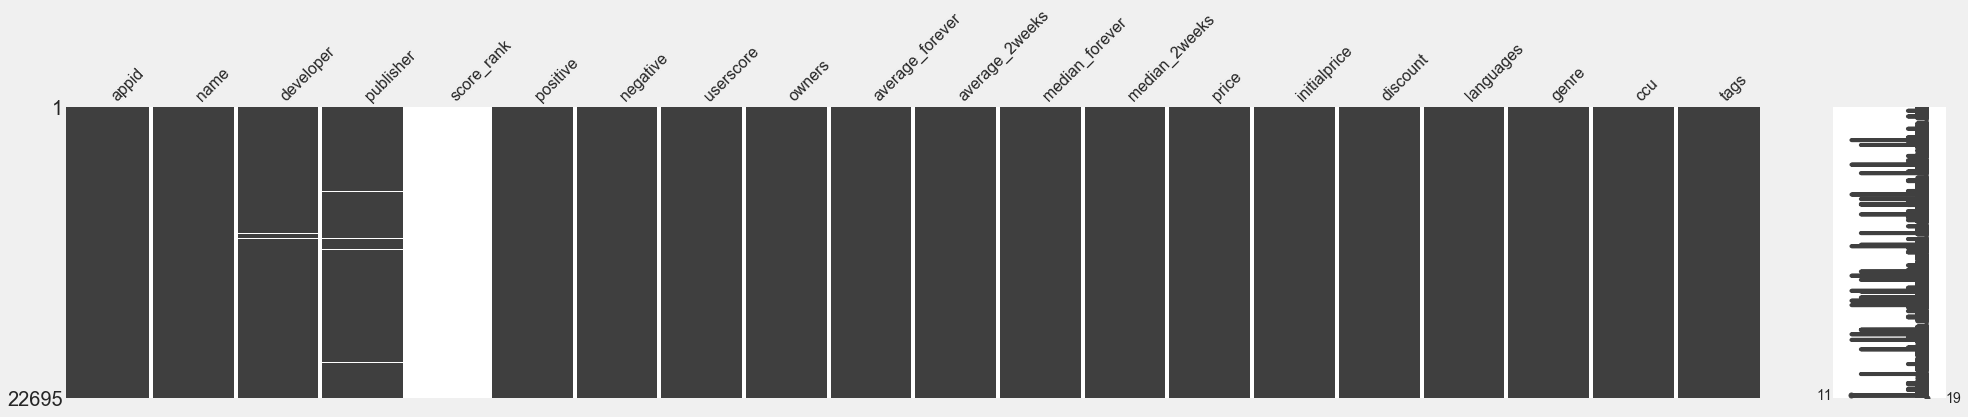

In [393]:
missingno.matrix(data_steamspy, figsize = (30,5))

Oh. Not entirely sure what `score_rank` is, but probably we don't want to keep it if it's almost entirely empty...anyway, on to merging:

In [380]:
data_full = pd.merge(data_steam, data_steamspy, on='appid', how='left', suffixes=('', '_steamspy')) #left join on appid

In [388]:
data_full.head(2)

,name,appid,developers,publishers,price,is_free,platforms,release_date,required_age,n_languages,n_packages,has_website,achievements,categories,genres,name_steamspy,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price_steamspy,initialprice,discount,languages,genre,ccu,tags
0,Rag Doll Kung Fu,1002,Mark Healey,Mark Healey,0,0,Windows,10/12/2005,0,1,1,1,0,Single-player; Multi-player,Indie,Rag Doll Kung Fu,Mark Healey,Mark Healey,NaN,44,18,0,"0 .. 20,000",0,0,0,0,999.0,999.0,0.0,English,Indie,0,"{'2D Fighter': 45, 'Martial Arts': 39, 'Multip..."
1,Darwinia,1500,Introversion Software,Introversion Software,0,0,Windows; Mac; Linux,07/14/2005,0,2,4,1,0,Single-player,Indie; Strategy,Darwinia,Introversion Software,Introversion Software,NaN,508,168,0,"500,000 .. 1,000,000",9,0,13,0,999.0,999.0,0.0,"English, German","Indie, Strategy",5,"{'Strategy': 109, 'Indie': 90, 'RTS': 62, 'Sin..."


First, let's check if there are cases where the `name` provided by Steam doesn't match the `name` provided by SteamSpy.

In [383]:
data_full.loc[data_full['name'] != data_full['name_steamspy']].count().head(1)

name    123
dtype: int64

Oof, there's actually a lot of these! Let's peep under the hood to figure out why:

In [384]:
name_check = data_full.loc[data_full['name'] != data_full['name_steamspy']]

In [387]:
name_check[['name', 'name_steamspy']].head()

,name,name_steamspy
7,Gumboy - Crazy Adventures™,Gumboy - Crazy Adventures
73,Dangerous High School Girls in Trouble!™,Dangerous High School Girls in Trouble!
85,Lucidity™,Lucidity
239,PixelJunk™ Eden,PixelJunk Eden
264,Sideway™ New York,Sideway New York


It looks like these are nearly all formatted changes due to special characters or characters in different languages. We'll keep the originals rather than what SteamSpy filtered out. We can check the same for `developers` and `publishers` and see that the only differences are due to formatting. Let's remove the redundant columns:

In [390]:
duplicate_cols = ['name_steamspy', 'developer', 'publisher', 'price_steamspy', 'languages']

In [391]:
data_full = data_full.drop(columns=duplicate_cols)

### SteamSpy Feature 1: Score Rank

I alluded to this feature a bit above, when we looked at the missing data for the SteamSpy dataset. It's almost entirely blank, so we certainly don't want to try to fill in the missing data!

In [396]:
print('Fraction of missing data: ', data_full['score_rank'].isnull().sum()/len(data_full))

Fraction of missing data:  1.0


Actually, it's entirely empty! 

In [398]:
data_full = data_full.drop(columns='score_rank')

### SteamSpy Feature 2 & 3: Positive & Negative

`Positive` and `negative` are the first features that could give us information about how well a game is perceived by it's audience! Thus, these will be some of our core features to be used in the Part 3 and 4 of this project. We ideally want to use them as ratio as well, probably binned in some way, which will be a feature we engineer later.

In [400]:
data_full['positive'].isnull().sum()

0

In [401]:
data_full['negative'].isnull().sum()

0

Cool, these features are actually already in the format we want! We can rename them though, so that they're a bit more obvious.

In [406]:
data_full.rename(columns={'positive':'positive_ratings', 'negative':'negative_ratings'},inplace=True)

### SteamSpy Feature 4: User Score

User Score is another measure of how well received a game is by its audience, but as it turns out, this is information that is most commonly provided for AAA games - although there are no missing values in the column, we can see quickly that every value is zero and thus, not very useful for us.

In [403]:
data_full['userscore'].isnull().sum()

0

In [404]:
data_full['userscore'].value_counts()

0    21729
Name: userscore, dtype: int64

In [405]:
data_full = data_full.drop(columns='userscore')

### SteamSpy Feature 5: Owners

The number of `owners` is arguably just as important as the ratings for a game, since "success" for a game should be some sort of combination of how many copies are purchased, how much the games are liked, how frequently the games are played, how long they're played (do you still play it 5 years later? 10 years later? I definitely still whip out Roller Coaster Tycoon every once in a while after what, 20 years?) 

Unfortunately, especially for small games, the `owners` feature has a bit of a caveat: it has massive ranges displayed from the max number to minimum number of owners, so we'll have to be careful with how much stock we place on this information and we definitely want to keep both the min and max values. The current format, however, is a little silly as the two extremes are separated with ellipses rather than a dash or something more common. Let's fix this and take a look at what "size" of ownership is most common:

In [408]:
data_full[['owners']].head()

,owners
0,"0 .. 20,000"
1,"500,000 .. 1,000,000"
2,"500,000 .. 1,000,000"
3,"500,000 .. 1,000,000"
4,"500,000 .. 1,000,000"


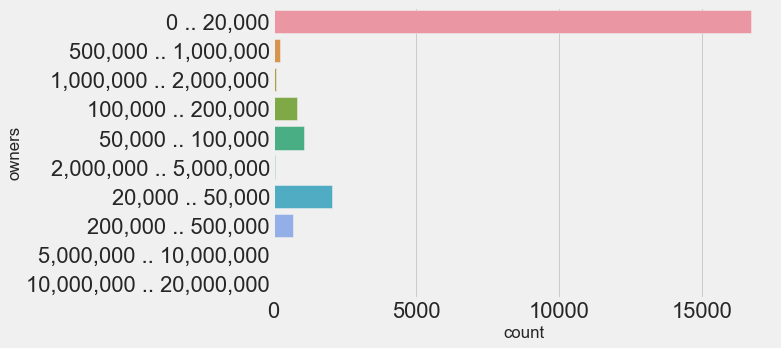

In [411]:
sns.set(font_scale=2)
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(8,5)) 
sns.countplot(y="owners", data=data_full);

### SteamSpy Features 6 & 7: Average and Median Playtimes

The next four columns, `average_forever`, `average_2weeks`, `median_forever`, and `median_2weeks` are somewhat poorly named, but they give us information about how often a game is played. The `2weeks` versions give the amount the games have been played in the past 2 weeks, but since our data is stagnant and we have no plans to update this dataset every two weeks, this is much less useful than the overall average and median playtimes. We'll drop the `2weeks` versions and take a look at the lifetime versions. Note that the values provided are in units of `minutes`.

### SteamSpy Feature 8 & 9: Initial Price & Discount

### SteamSpy Feature 10: Genre

### SteamSpy Feature 11: CCU

### SteamSpy Feature 12: Tags

In [407]:
data_full

,name,appid,developers,publishers,price,is_free,platforms,release_date,required_age,n_languages,n_packages,has_website,achievements,categories,genres,positive_ratings,negative_ratings,owners,average_forever,average_2weeks,median_forever,median_2weeks,initialprice,discount,genre,ccu,tags
0,Rag Doll Kung Fu,1002,Mark Healey,Mark Healey,0,0,Windows,10/12/2005,0,1,1,1,0,Single-player; Multi-player,Indie,44,18,"0 .. 20,000",0,0,0,0,999.0,0.0,Indie,0,"{'2D Fighter': 45, 'Martial Arts': 39, 'Multip..."
1,Darwinia,1500,Introversion Software,Introversion Software,0,0,Windows; Mac; Linux,07/14/2005,0,2,4,1,0,Single-player,Indie; Strategy,508,168,"500,000 .. 1,000,000",9,0,13,0,999.0,0.0,"Indie, Strategy",5,"{'Strategy': 109, 'Indie': 90, 'RTS': 62, 'Sin..."
2,Uplink,1510,Introversion Software,Introversion Software,$9.99,0,Windows; Mac; Linux,08/23/2006,0,1,2,1,0,Single-player,Indie; Strategy,1725,162,"500,000 .. 1,000,000",280,0,119,0,999.0,0.0,"Indie, Strategy",12,"{'Hacking': 209, 'Indie': 145, 'Strategy': 132..."
3,DEFCON,1520,Introversion Software,Introversion Software,$9.99,0,Windows; Mac; Linux,09/29/2006,0,5,3,1,22,Single-player; Multi-player,Indie; Strategy,2277,378,"500,000 .. 1,000,000",177,140,124,140,999.0,0.0,"Indie, Strategy",23,"{'Strategy': 241, 'Indie': 150, 'Wargame': 107..."
4,Multiwinia,1530,Introversion Software,Introversion Software,$9.99,0,Windows; Mac,09/19/2008,0,5,3,1,12,Single-player; Multi-player; Steam Achievements,Indie,394,80,"500,000 .. 1,000,000",15,0,17,0,999.0,0.0,Indie,1,"{'Indie': 56, 'RTS': 34, 'Strategy': 32, 'Mult..."
5,The Ship: Murder Party,2400,Outerlight Ltd.,Blazing Griffin Ltd.,$9.99,1,Windows,07/11/2006,0,8,2,1,0,Single-player; Multi-player; Steam Trading Car...,Action; Indie; RPG,4916,811,"1,000,000 .. 2,000,000",228,0,246,0,999.0,0.0,"Action, Indie, RPG",15,"{'Multiplayer': 370, 'Indie': 171, 'First-Pers..."
6,The Ship: Single Player,2420,Outerlight Ltd.,Blazing Griffin Ltd.,0,0,Windows,11/20/2006,0,8,1,1,0,Single-player,Action; Indie; RPG,610,257,"100,000 .. 200,000",82,0,51,0,999.0,0.0,"Action, Indie, RPG",2,"{'Action': 338, 'Indie': 49, 'RPG': 39, 'Singl..."
7,Gumboy - Crazy Adventures™,2520,"CINEMAX, s.r.o.","CINEMAX, s.r.o.",$4.99,1,Windows,12/19/2006,0,3,1,1,0,Single-player,Casual; Indie,54,51,"50,000 .. 100,000",0,0,0,0,499.0,0.0,"Casual, Indie",0,"{'Casual': 36, 'Indie': 32, 'Physics': 28, 'Ac..."
8,ThreadSpace: Hyperbol,2720,Iocaine Studios,Atari,$4.99,0,Windows,07/12/2007,0,1,3,1,0,Single-player; Multi-player; Includes level ed...,Action; Indie; Strategy,32,10,"0 .. 20,000",0,0,0,0,499.0,0.0,"Action, Indie, Strategy",1,"{'Multiplayer': 29, 'Action': 26, 'Strategy': ..."
9,Plants vs. Zombies GOTY Edition,3590,"PopCap Games, Inc.","PopCap Games, Inc.",$4.99,0,Windows; Mac,05/05/2009,0,1,1,0,21,Single-player; Steam Achievements; Remote Play...,Strategy,23334,820,"2,000,000 .. 5,000,000",1055,184,515,267,499.0,0.0,Strategy,9093,"{'Tower Defense': 1024, 'Zombies': 900, 'Strat..."


In [58]:
import sqlite3
from sqlite3 import Error

In [68]:
def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

In [67]:
#con = sqlite3.connect("data/data_steam.sqlite")
#cursor = con.cursor()
#data_steam.to_sql('data_steam', con=con)